In [2]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from tqdm import tqdm
%matplotlib inline

In [32]:
client = MongoClient("localhost:27017")
database = client["golos_comments"]
database_1 = client["steemdb_1"]
database_2 = client["golos_all_tsx"]
collection_account = database["account"]
collection_comment = database["comment"]
collection_feed_publish = database_2["feed_publish"]
collection_global_properties = database_1["global_properties"]

## Constants

In [3]:
PERCENT = 10000
s = 2000000000000.0
precision = 3

# Load Data

## Load topics from MongoDB

Find all comments with nonzero votes

In [129]:
comment_df = pd.DataFrame(list(collection_comment.find({'net_votes' :{'$gt':0}
                                                        },                                              

                                                     {'_id': 1, 
                                                      'author': 1, 
                                                      'last_payout': 1, 
                                                      'reward_weight' : 1,
                                                      'net_rshares' : 1,
                                                      'net_votes' : 1,
                                                      'total_payout_value' : 1,
                                                      'curator_payout_value': 1,
                                                      'pending_payout_value': 1,
                                                      'max_accepted_payout':1,
                                                      'root_comment' : 1,
                                                      'depth' : 1,
                                                      'active_votes':1,
                                                      'created':1,
                                                     'test':1}
                                                     )))

Count 
    - last payout date, 
    - difference between creation and payout time, 
    - payout value

In [130]:
comment_df['last_payout'] = comment_df['last_payout'].map(lambda x: x if x==x else datetime(2000,1,1))
comment_df['last_payout_date'] = comment_df['last_payout'].map(lambda x: x.date())
comment_df.loc[:,'delta_payout_time'] = comment_df.apply(lambda x: x['last_payout'] - x['created'], axis=1)
comment_df.loc[:,'payout_value'] = comment_df['total_payout_value']+ \
                                   comment_df['curator_payout_value']+ \
                                   comment_df['pending_payout_value']

Save weights of each vote from the 1st till the 3rd of February

In [201]:
comment_votes_df = comment_df[(comment_df['created']>datetime(2017,11,21)) & \
                              (comment_df['curator_payout_value']>0)]
comment_votes_week_df = comment_votes_df[(comment_votes_df['created']>datetime(2018,2,1))& \
                                         (comment_votes_df['created']<datetime(2018,2,3))]
new_df_list = []
for i in comment_votes_week_df.index:
    row = comment_votes_week_df.loc[i,:]
    sum_weight = 0
    for item in row['active_votes']:
        sum_weight+=item['weight']
    if sum_weight>0:
        for item in row['active_votes']:
            new_df_list.append([row['_id'], row['author'], row['created'], row['last_payout'],  item['voter'], item['weight']/sum_weight])
curators_df = pd.DataFrame(data=new_df_list, columns=['_id', 'author', 'created', 'last_payout', 'voter', 'weight'])

Add info about rshares calculated with alternative functions

In [202]:
alternative_comment_df = pd.read_csv("comments_with_alternative_rshares.csv")

In [203]:
alternative_comment_df["_id"] = alternative_comment_df["author"] + "/" + alternative_comment_df["permlink"]

In [204]:
alternative_comment_df = alternative_comment_df.drop(["payout_value"], axis=1)

In [205]:
merged_comment_df = pd.merge(comment_df, alternative_comment_df, left_on="_id", right_on="_id", how="inner")

Count coefficient of curators reward for each comment

In [206]:
merged_comment_df["curators_coefficient"] = merged_comment_df["curator_payout_value"] / merged_comment_df["payout_value"]
merged_comment_df["curators_coefficient"] = merged_comment_df["curators_coefficient"].fillna(0)

Add info about categories of curators

In [207]:
authors = pd.read_csv("all_cat.csv")

In [208]:
authors = authors[["cat", "author"]].drop_duplicates()

In [216]:
rewards_with_curators = pd.merge(curators_df, authors, left_on="voter", right_on="author", how="right")

In [217]:
rewards_with_curators_and_coefficients = pd.merge(
    rewards_with_curators[["_id", "voter", "weight", "cat"]], 
    merged_comment_df[[
        "_id", 
        "curators_coefficient", 
        'payout_rshares2', 
        'payout_rshares_linear', 
        'payout_rshares15', 
        'payout_rshares2_2', 
        "payout_rshares_compose"
    ]], 
    left_on="_id", 
    right_on="_id", 
    how="left"
)

In [218]:
rewards_with_curators_and_coefficients["curators_coefficient"] = rewards_with_curators_and_coefficients["curators_coefficient"].fillna(0)

In [219]:
rewards_with_curators_and_coefficients["cat"] = rewards_with_curators_and_coefficients["cat"].fillna("Независимые авторы")

Count payout for each curator according the weight of his vote

In [220]:
for f in ['rshares2', 
          'rshares_linear', 
          'rshares15', 
          'rshares2_2', 
          "rshares_compose"]:
    rewards_with_curators_and_coefficients['curator_payout_' + f] = rewards_with_curators_and_coefficients['payout_' + f]*rewards_with_curators_and_coefficients['curators_coefficient'] *rewards_with_curators_and_coefficients['weight'] 

Find a distribution of rewards calculated with different rshares functions by curator groups

In [221]:
stacked_df = rewards_with_curators_and_coefficients.fillna(0).groupby("cat")[['curator_payout_' + x for x in ['rshares2', 'rshares_linear', 'rshares15', 'rshares2_2', "rshares_compose"]]].sum()

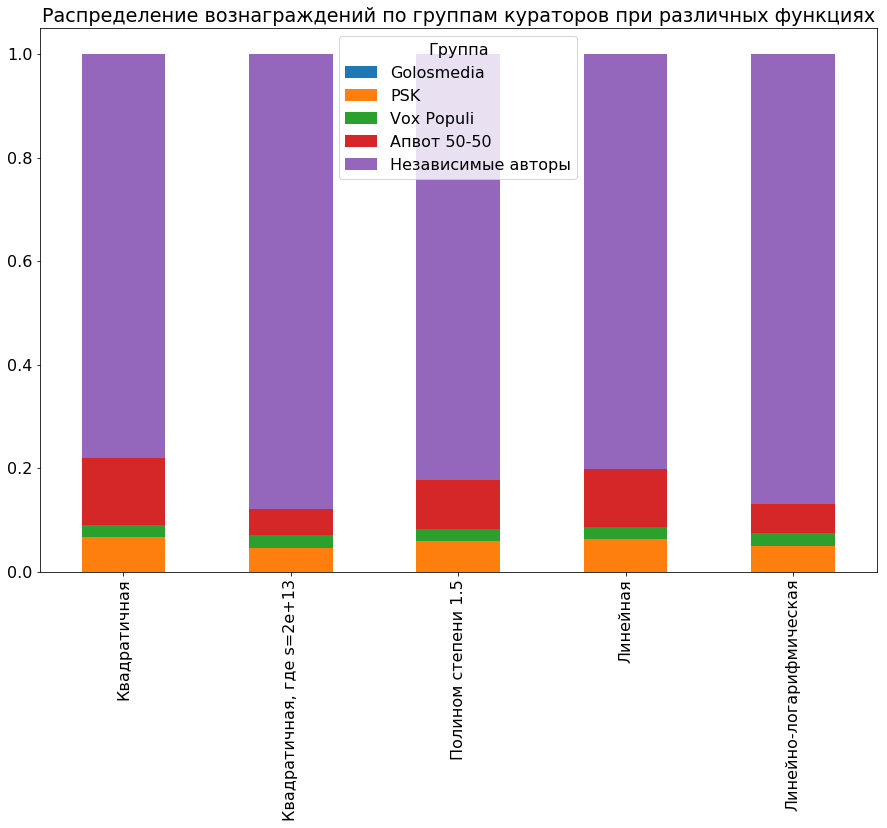

In [222]:
mpl.rcParams['figure.figsize'] = (18.0, 9.0)
plt.rcParams.update({'font.size': 16})
plot = (stacked_df / stacked_df.sum()).T.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title("Распределение вознаграждений по группам кураторов при различных функциях")
plt.legend(title="Группа")
plot.set_xticklabels(["Квадратичная",  
                      "Квадратичная, где s=2e+13",
                      "Полином степени 1.5",                       
                      "Линейная", 
                      "Линейно-логарифмическая"])
plt.show()